<a href="https://colab.research.google.com/github/Rafe2001/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,confusion_matrix

In [2]:
df_train = pd.read_csv("/content/train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv('/content/val.txt',delimiter=';',names=['text','label'])

In [3]:
#Concatinate the two data frames as well as using cross validation
df=pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

In [4]:
df

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
17995,im having ssa examination tomorrow in the morn...,sadness
17996,i constantly worry about their fight against n...,joy
17997,i feel its important to share this info for th...,joy
17998,i truly feel that if you are passionate enough...,joy


In [5]:
df.select_dtypes(include=['object']).columns

Index(['text', 'label'], dtype='object')

In [6]:
df.select_dtypes(exclude=['object']).columns

Index([], dtype='object')

In [7]:
df['label'].value_counts()

joy         6066
sadness     5216
anger       2434
fear        2149
love        1482
surprise     653
Name: label, dtype: int64

Text(0, 0.5, 'count')

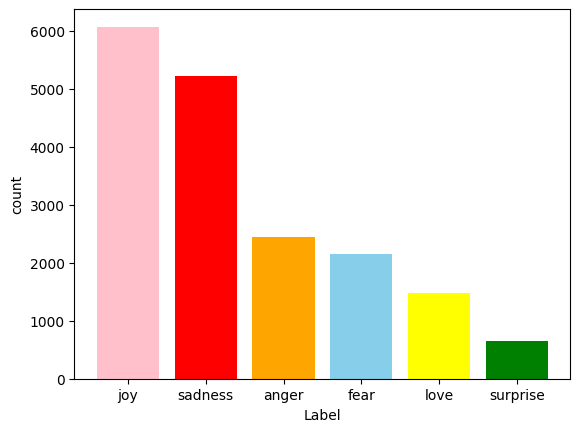

In [8]:
# Now we'll check for various target labels using barplot
plt.bar(list(df['label'].value_counts().keys()),list(df['label'].value_counts()),color=['pink','red','orange','skyblue','yellow','green'])
plt.xlabel("Label")
plt.ylabel('count')

**As we can see that, we have 6 labels or targets in the dataset. We can make a multi-class classifier for Sentiment Analysis. But, for the sake of simplicity, we will merge these labels into two classes, i.e. Positive and Negative sentiment.**

1. **Positive Sentiment – “joy”,”love”,”surprise”**
2. **Negative Sentiment – “anger”,”sadness”,”fear”** 

In [9]:
def custom_encoder(df):
  df.replace(to_replace='joy',value=1,inplace=True)
  df.replace(to_replace='love',value=1,inplace=True)
  df.replace(to_replace='surprise',value=1,inplace=True)
  df.replace(to_replace='sadness',value=0,inplace=True)
  df.replace(to_replace='fear',value=0,inplace=True)
  df.replace(to_replace='anger',value=0,inplace=True)

In [10]:
custom_encoder(df['label'])

<Axes: xlabel='label', ylabel='count'>

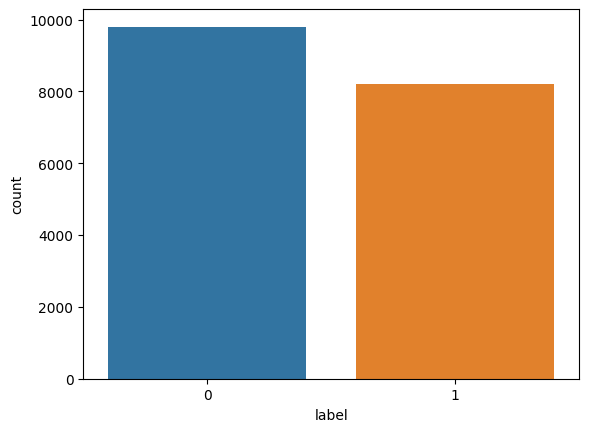

In [11]:
sns.countplot(x='label',data=df)

# Data Preprocessing

Now, we will perform some pre-processing on the data before converting it into vectors and passing it to the machine learning model.

In [12]:
#object of WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
corpus = text_transformation(df['text'])

Now, we will create a Word Cloud. It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words. This gives us a little insight into, how the data looks after being processed through all the steps until now.

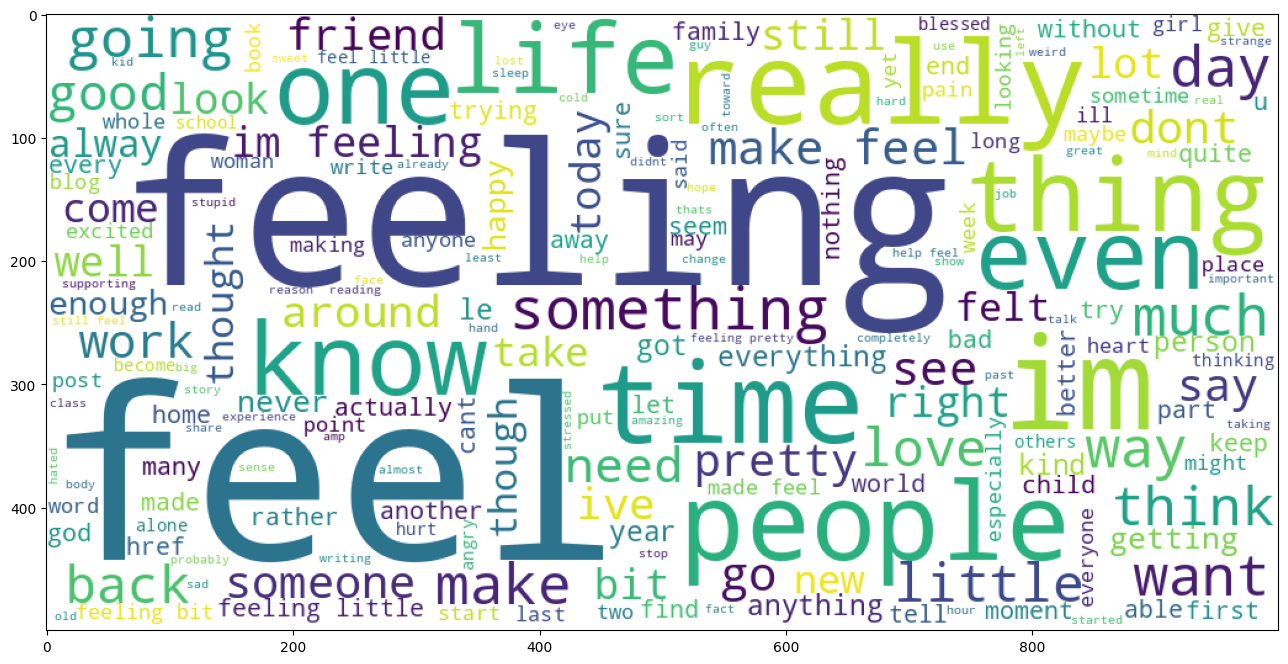

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,8
word_cloud = " "
for row in corpus:
  for word in row:
    word_cloud+= " ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

# Bag of Words

Now, we will use the Bag of Words Model(BOW), which is used to represent the text in the form of a bag of words,i.e. the grammar and the order of words in a sentence are not given any importance, instead, multiplicity,i.e. (the number of times a word occurs in a document) is the main point of concern.

In [15]:
cv = CountVectorizer(ngram_range=(1,2))
train_data = cv.fit_transform(corpus)
x = train_data
y = df.label 

Ngram is a sequence of ‘n’ of words in a row or sentence. ‘ngram_range’ is a parameter, which we use to give importance to the combination of words, such as, “social media” has a different meaning than “social” and “media” separately.

# Model Creation

In [51]:
rfc = RandomForestClassifier(bootstrap=True,max_depth=None,min_samples_leaf=1,min_samples_split=5,n_estimators=500)
rfc.fit(x,y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', min_samples_split=5,
                       n_estimators=500)

# Test Data Transformation

In [53]:
test_df = pd.read_csv('/content/test.txt',delimiter=';',names=['text','label'])
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

# Model Evaluation

Accuracy score:  0.962
Precision score:  0.9627192982456141
Recall score:  0.9543478260869566
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1080
           1       0.96      0.95      0.96       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



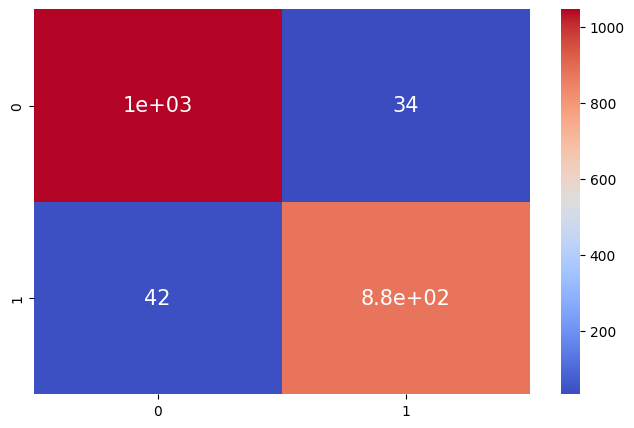

In [54]:
rcParams['figure.figsize'] = 8,5
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,annot_kws={'size':15},cmap='coolwarm')
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print("Accuracy score: ",acc_score)
print("Precision score: ",pre_score)
print("Recall score: ",rec_score)
print('-'*50)
print(classification_report(y_test,predictions))

# ROC Curve

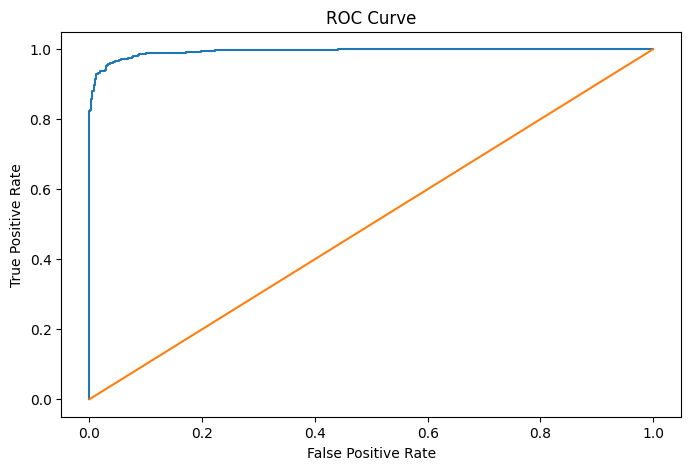

In [55]:
predictions_probability = rfc.predict_proba(testdata)
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can see that our model performed very well in classifying the sentiments, with an Accuracy score, Precision and  Recall of approx 96%. And the roc curve and confusion matrix are great as well which means that our model is able to classify the labels accurately, with fewer chances of error.

# Sentiment Prediction from Text

In [60]:
#predict for the custom input:
def expression_check(predict_input):
  if predict_input == 0:
    print("Sentiment of the statement is negative")
  elif predict_input == 1:
    print("Sentiment of the statement is positive")
  else:
    print("Invalid Statement")

In [61]:
def sentiment_predictor(input):
  input = text_transformation(input)
  transformed_input = cv.transform(input)
  prediction = rfc.predict(transformed_input)
  expression_check(prediction)

In [62]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
input3 = ["i'm happy and i love you"]
input4= ['Today is very bad day for me at school.']

sentiment_predictor(input1)
sentiment_predictor(input2)
sentiment_predictor(input3)
sentiment_predictor(input4)

Sentiment of the statement is negative
Sentiment of the statement is positive
Sentiment of the statement is positive
Sentiment of the statement is negative
